In [2]:
import os
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

# 문제: 년별 분기별 대여건수
서울시 열린데이터 https://data.seoul.go.kr/ 에서 제공하는 서울특별시_공공자전거 일별 대여건수_(2018~2019.03).csv를 분석해보자. 파일은 웹 검색을 해서 다운로드해서 사용하면 된다. 데이터는 일자별로, 대여건수이이고, 몇 줄만 출력해보면 다음과 같다.

## 데이터 읽기
서울시 열린데이터에서 데이터 서울특별시_공공자전거 일별 대여건수_(2018~2019.03).csv 를 다운로드 받아서 저장한다. csv 형식으로 schema는 자동 인식하도록 읽는다. 일자는 timestamp로 건수는 integer로 인식되었다.

In [4]:
_bicycle = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/서울특별시_공공자전거 일별 대여건수_(2018_2019.03).csv')

In [5]:
_bicycle.printSchema()

root
 |-- 대여일자: string (nullable = true)
 |-- 대여건수: integer (nullable = true)



In [6]:
_bicycle.count()

455

In [7]:
_bicycle.show(5)

+----------+--------+
|  대여일자|대여건수|
+----------+--------+
|2018-01-01|    4950|
|2018-01-02|    7136|
|2018-01-03|    7156|
|2018-01-04|    7102|
|2018-01-05|    7705|
+----------+--------+
only showing top 5 rows



---
## 컬럼명 변경

In [8]:
bicycle=_bicycle\
    .withColumnRenamed("대여일자", "Date")\
    .withColumnRenamed("대여건수", "Count")

In [10]:
bicycle.show(5)

+----------+-----+
|      Date|Count|
+----------+-----+
|2018-01-01| 4950|
|2018-01-02| 7136|
|2018-01-03| 7156|
|2018-01-04| 7102|
|2018-01-05| 7705|
+----------+-----+
only showing top 5 rows



---
## 컬럼 만들기: substr
substr() 함수는 인자가 2개로서, 앞글자 '1'은 시작 '4'는 4글자를 의미한다.

In [11]:
bicycle=bicycle.withColumn("year",bicycle.Date.substr(1, 4)) #1~4번째 추출해서 year에만듦

In [12]:
bicycle.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- year: string (nullable = true)



In [13]:
bicycle=bicycle.withColumn("month",bicycle.Date.substr(6, 2))

In [15]:
bicycle.show(5)

+----------+-----+----+-----+
|      Date|Count|year|month|
+----------+-----+----+-----+
|2018-01-01| 4950|2018|   01|
|2018-01-02| 7136|2018|   01|
|2018-01-03| 7156|2018|   01|
|2018-01-04| 7102|2018|   01|
|2018-01-05| 7705|2018|   01|
+----------+-----+----+-----+
only showing top 5 rows



---
## 컬럼 만들기: F 함수
함수를 이용해 년, 월, 일 등을 추출할 수 있다. 먼저 앞서 생성된 column을 삭제하고 나서 해보자. 여러 컬럼을 삭제하기 위해서는 *를 앞에 붙여 준다. 물론 하나씩 삭제할 수도 있고, 그러면 별표는 불필요하다.

In [16]:
# year, month 컬럼 삭제, Date, Count 컬럼만 남김
columns_to_drop = ['year','month']
df = bicycle.drop(*columns_to_drop) # *: list를 unpack, **: dictionary를 unpack

In [17]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Count: integer (nullable = true)



In [18]:
# pyspark.sql.functions의 year(), month() 함수를 사용하여 년, 월을 추출
import pyspark.sql.functions as F
bicycle = bicycle\
    .withColumn('year', F.year('date'))\
    .withColumn('month', F.month('date'))

In [19]:
bicycle.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [20]:
bicycle.show(5)

+----------+-----+----+-----+
|      Date|Count|year|month|
+----------+-----+----+-----+
|2018-01-01| 4950|2018|    1|
|2018-01-02| 7136|2018|    1|
|2018-01-03| 7156|2018|    1|
|2018-01-04| 7102|2018|    1|
|2018-01-05| 7705|2018|    1|
+----------+-----+----+-----+
only showing top 5 rows



In [21]:
bicycle.filter(bicycle.month == 2).show(3)

+----------+-----+----+-----+
|      Date|Count|year|month|
+----------+-----+----+-----+
|2018-02-01| 5821|2018|    2|
|2018-02-02| 6557|2018|    2|
|2018-02-03| 3499|2018|    2|
+----------+-----+----+-----+
only showing top 3 rows



---
## 분기
1월 2월 3월은 1분기, 4-6월 2분기, 7-9는 3분기, 10-12는 4분기로 구분한다.

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
def classifyQuarter(s):
    q=""
    if 1<=s and s< 4:
        q="Q1"
    elif 4<=s and s<7:
        q="Q2"
    elif 7<=s and s<10:
        q="Q3"
    elif 10<=s and s<=12:
        q="Q4"
    else:
        q="no"
    return q

In [23]:
#함수를 직접 호출하는것은 안된다! udf()이용하여 호출

quarter_udf = udf(classifyQuarter, StringType()) #함수이름, 반환형

In [24]:
bicycle=bicycle.withColumn("quarter", quarter_udf(bicycle.month))

In [25]:
bicycle.groupBy('quarter').count().show()

+-------+-----+
|quarter|count|
+-------+-----+
|     Q2|   91|
|     Q1|  180|
|     Q3|   92|
|     Q4|   92|
+-------+-----+



In [26]:
bicycle.show(5)

+----------+-----+----+-----+-------+
|      Date|Count|year|month|quarter|
+----------+-----+----+-----+-------+
|2018-01-01| 4950|2018|    1|     Q1|
|2018-01-02| 7136|2018|    1|     Q1|
|2018-01-03| 7156|2018|    1|     Q1|
|2018-01-04| 7102|2018|    1|     Q1|
|2018-01-05| 7705|2018|    1|     Q1|
+----------+-----+----+-----+-------+
only showing top 5 rows



---
## 년도별 대여건수 합계 (과제 1-1)

In [27]:
bicycle.groupBy('year').agg({"count":"sum"}).show()

+----+----------+
|year|sum(count)|
+----+----------+
|2018|  10124874|
|2019|   1871935|
+----+----------+



---
## 분기별 대여건수 합계

In [28]:
bicycle.groupBy('quarter').agg({"count":"sum"}).show()

+-------+----------+
|quarter|sum(count)|
+-------+----------+
|     Q2|   2860617|
|     Q1|   2667704|
|     Q3|   3585513|
|     Q4|   2882975|
+-------+----------+



In [29]:
bicycle.groupBy('quarter').agg({"count":"avg"}).show()

+-------+------------------+
|quarter|        avg(count)|
+-------+------------------+
|     Q2|31435.351648351647|
|     Q1|14820.577777777778|
|     Q3|38972.967391304344|
|     Q4|31336.684782608696|
+-------+------------------+



---
## 년도별, 월별 (분기별) 대여건수 합계 (과제 1-2)

In [30]:
bicycle.groupBy('year').pivot('month').agg({"count":"sum"}).show()
#딕셔너리이므로 groupBy를 2번 쓰는게아니라 groupBy, pivot 이렇게 사용
# +----+ 마크다운 table 명령어

+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|year|     1|     2|     3|     4|     5|      6|      7|      8|      9|     10|    11|    12|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|2018|164367|168741|462661|687885|965609|1207123|1100015|1037505|1447993|1420621|961532|500822|
|2019|495573|471543|904819|  null|  null|   null|   null|   null|   null|   null|  null|  null|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+



In [31]:
bicycle.groupBy('year').pivot('quarter').agg({"count":"sum"}).show()

+----+-------+-------+-------+-------+
|year|     Q1|     Q2|     Q3|     Q4|
+----+-------+-------+-------+-------+
|2018| 795769|2860617|3585513|2882975|
|2019|1871935|   null|   null|   null|
+----+-------+-------+-------+-------+



---
## Pandas pivot

In [32]:
import pandas as pd
import numpy as np
bicycleP = bicycle.toPandas() 

In [33]:
bicycleP.info() #Pandas의 info() 함수는 DataFrame의 컬럼, 데이터타입 dtypes를 출력

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     455 non-null    object
 1   Count    455 non-null    int32 
 2   year     455 non-null    int32 
 3   month    455 non-null    int32 
 4   quarter  455 non-null    object
dtypes: int32(3), object(2)
memory usage: 12.6+ KB


In [34]:
# 년도별 대여건수 합계
bicycleP.groupby('year').aggregate({'Count':'sum'})

,Count
year,
2018,10124874
2019,1871935


In [35]:
# 년도별, 월별 대여건수 합계

pd.pivot_table(bicycleP, values = 'Count', index = ['year'], columns = ['month'], aggfunc= 'sum')
#index는 행, columns는 열 데이터를 정의

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2018,164367.0,168741.0,462661.0,687885.0,965609.0,1207123.0,1100015.0,1037505.0,1447993.0,1420621.0,961532.0,500822.0
2019,495573.0,471543.0,904819.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# 2018년만 선택해서 년도별 x 분기별 대여건수를 출력
bicycleP2018=bicycleP[bicycleP['year']==2018]

In [37]:
bicycleP2018byQ = pd.pivot_table(bicycleP2018, values = 'Count', index = ['year'], columns = ['quarter'], aggfunc= 'sum')

In [38]:
bicycleP2018byQ.iloc[:,0:4]

quarter,Q1,Q2,Q3,Q4
year,,,,
2018,795769,2860617,3585513,2882975


---
## 그래프   (과제 1-3)
앞장 RDD에서 만들어진 단어빈도는 리스트에 저장되었다. 따라서 리스트에서 데이터를 추출하여 그래프를 그렸다. groupBy에서 생성된 월별 대여건수는 pandas로 변환하여 그려보자.

In [39]:
sumMonthly=bicycle.groupBy('year').pivot('month').agg({"count":"sum"})

In [40]:
pdf=sumMonthly.toPandas()

In [41]:
pdf.head()

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,2018,164367,168741,462661,687885.0,965609.0,1207123.0,1100015.0,1037505.0,1447993.0,1420621.0,961532.0,500822.0
1,2019,495573,471543,904819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


위 데이터에서 'year' 컬럼이 없어야 그래프를 그릴 수 있다.
- drop() 명령어에 삭제할 컬럼명 'year'와 1을 적어준다. 0은 행 (index), 1은 컬럼을 삭제한다는 의미이다.
- transpose() 함수를 통해 열로 변환하여 (행 데이터는 plot을 할 수 없다), 그래프를 그린다.

In [42]:
my=pdf.drop('year', 1).transpose()

In [43]:
my #위 pdf를 변환한 my를 출력하면, 명령어가 적용되어 year 컬럼이 삭제되고, transpose되어 있다.

,0,1
1,164367.0,495573.0
2,168741.0,471543.0
3,462661.0,904819.0
4,687885.0,NaN
5,965609.0,NaN
6,1207123.0,NaN
7,1100015.0,NaN
8,1037505.0,NaN
9,1447993.0,NaN
10,1420621.0,NaN


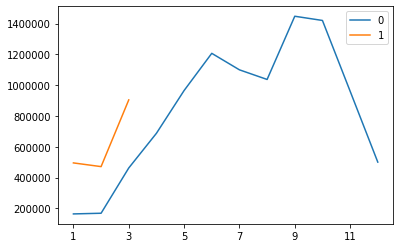

In [44]:
my.plot(kind='line') #plot() 함수는 컬럼을 적지 않으면 모든 컬럼에 대해서 plot한다.

